In [1]:
# import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
from matplotlib.colors import DivergingNorm
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as mpl
mpl.rcParams['figure.dpi'] = 300

# Map features

In [2]:
### Establish higher res cartopy data
coastline_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m')
ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m')
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m')

states_50m = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', '50m')

# Full averages

In [3]:
### Read data
## Coordinates
wtk_coords = np.loadtxt('data/wtk/coordinates_wtk.csv')
ca20_coords = np.loadtxt('data/ca20/coordinates_ca20.csv')

## Dataset-average of 100m winds
winds_all_wtk_interp = pd.read_csv("data/wtk/full_avg_wtk.csv")
winds_all_ca20 = np.loadtxt("data/ca20/full_avg_ca20.csv", delimiter=',')

# Cleanup
n_coords_ca20 = winds_all_ca20.shape[0]
winds_all_ca20 /= 100
winds_all_wtk_interp['Winds'] /= 100

In [4]:
### Calculate lat/long info for the map
lat_vec = ca20_coords[:,0]
long_vec = ca20_coords[:,1]

LAT_MIN = lat_vec.min()
LAT_MAX = lat_vec.max()
LAT_MEAN = lat_vec.mean()
LONG_MIN = long_vec.min()
LONG_MAX = long_vec.max()
LONG_MEAN = long_vec.mean()
MAP_BOUNDS = [LONG_MIN, LONG_MAX, LAT_MIN, LAT_MAX]

In [5]:
### Process shapefiles for lease regions
## Load shapefiles
df = gpd.read_file('data/shapefiles/CA_Call_Areas_2018_09_26.shp')

## Convert projection to match what we use in Cartopy
crs = ccrs.LambertConformal(central_longitude=LONG_MEAN, central_latitude=LAT_MEAN)
crs_proj4 = crs.proj4_init
df_proj = df.to_crs(crs_proj4)

## Merge (aka dissolve) geometries by lease area
df_proj_group = df_proj.dissolve(by='AREA_NM')

In [6]:
### Calculate difference and cleanup NaNs
diff20_vec = winds_all_ca20 - winds_all_wtk_interp['Winds']
diff20 = np.vstack((diff20_vec, ca20_coords.T)).T
diff20 = pd.DataFrame(diff20, columns=['Winds', 'Lat', 'Long'])

winds_all_wtk_interp = winds_all_wtk_interp.dropna()
diff20 = diff20.dropna()

/Users/orybchuk/opt/anaconda3/envs/wfp/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
/Users/orybchuk/opt/anaconda3/envs/wfp/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


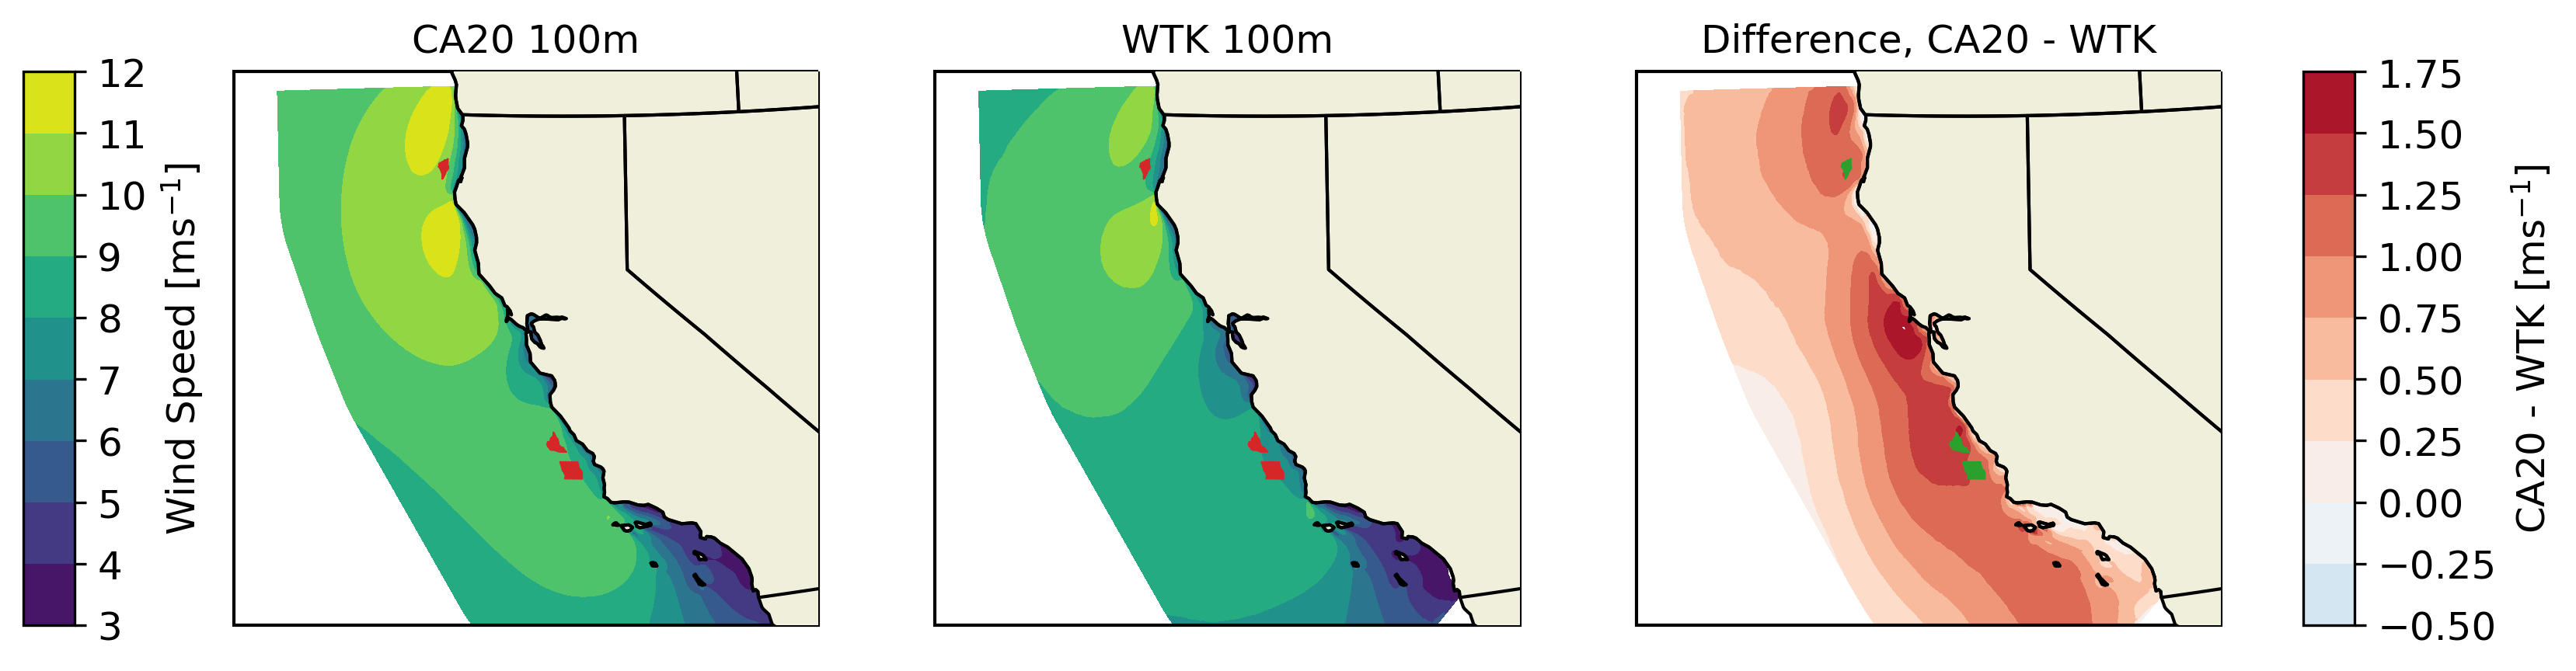

In [7]:
### Difference between BOEM20 and WTK
proj = ccrs.LambertConformal(central_longitude=LONG_MEAN, central_latitude=LAT_MEAN)
fig, ax = plt.subplots(1, 3, figsize=(11, 3.5), subplot_kw=dict(projection=proj),
                          sharex=True, sharey=True)

ax[0].set_extent(MAP_BOUNDS)

ticks_wind = np.linspace(3, 12, 10)
ticks_diff = np.linspace(-0.5, 1.75, 10)

im1 = ax[0].tricontourf(long_vec,
                        lat_vec,
                        winds_all_ca20,
                        ticks_wind, transform=ccrs.Geodetic())
im2 = ax[1].tricontourf(winds_all_wtk_interp['Long'],
                        winds_all_wtk_interp['Lat'],
                        winds_all_wtk_interp['Winds'],
                        ticks_wind, transform=ccrs.Geodetic())
im3 = ax[2].tricontourf(diff20['Long'],
                        diff20['Lat'],
                        diff20['Winds'],
                        ticks_diff, transform=ccrs.Geodetic(),
                        cmap=plt.cm.RdBu_r, norm=DivergingNorm(0, vmin=-2, vmax=2))



# Colorbar
cax1 = fig.add_axes([ax[0].get_position().x1-0.31,ax[0].get_position().y0,0.02,ax[0].get_position().y1-ax[0].get_position().y0])
cbar1 = fig.colorbar(im1, cax=cax1, ticks=ticks_wind)
cbar1.set_label('Wind Speed [ms$^{-1}$]', fontsize=12)
cbar1.ax.tick_params(labelsize=12) 
cax2 = fig.add_axes([ax[-1].get_position().x0+0.26,ax[-1].get_position().y0,0.02,ax[-1].get_position().y1-ax[-1].get_position().y0])
cbar2 = fig.colorbar(im3, cax=cax2, ticks=ticks_diff)
cbar2.set_label('CA20 - WTK [ms$^{-1}$]', fontsize=12)
cbar2.ax.tick_params(labelsize=12)

# Subtitles
ax[0].set_title("CA20 100m")
ax[1].set_title("WTK 100m")
ax[2].set_title("Difference, CA20 - WTK")

## Add map features
# Land
ax[0].add_feature(land_50m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k')
ax[1].add_feature(land_50m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k')
ax[2].add_feature(land_50m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k')

# States
ax[0].add_feature(states_50m, facecolor='None', zorder=101, edgecolor='k')
ax[1].add_feature(states_50m, facecolor='None', zorder=101, edgecolor='k')
ax[2].add_feature(states_50m, facecolor='None', zorder=101, edgecolor='k')

ax[0].add_geometries(df_proj_group['geometry'], crs=crs, edgecolor='C3', facecolor="C3", linewidth=0.3)
ax[1].add_geometries(df_proj_group['geometry'], crs=crs, edgecolor='C3', facecolor="C3", linewidth=0.3)
ax[2].add_geometries(df_proj_group['geometry'], crs=crs, edgecolor='C2', facecolor="C2", linewidth=0.3)


# plt.savefig("../figures/fig02.png", bbox_inches='tight')
# plt.savefig("../figures/fig02.eps", bbox_inches='tight')
# plt.savefig("../figures/fig02.pdf", bbox_inches='tight')

plt.show()